# Regents-races data exploration

In [11]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline

In [12]:
df = pd.read_csv('data/race_results',index_col=0)

In [81]:
df.head(3)

,Year,Race,Place,Name,Bib No,Gun Time,Net Time,Category,Categ Pos,Gender,Gender Pos,Club,Lap 1 Time,Lap 2 Time,Lap 3 Time
0,2011,0,1,Richard Scott,2042,32.633333,NaN,Senior,1,Male,1,Highgate Harriers,NaN,NaN,NaN
1,2011,0,2,Hassan Raini,2044,33.200000,NaN,Senior,2,Male,2,Belgrave Harriers,NaN,NaN,NaN
2,2011,0,3,Jonathan Stead,823,33.500000,NaN,Senior,3,Male,3,Herne Hill Harriers,NaN,NaN,NaN


## Race participation

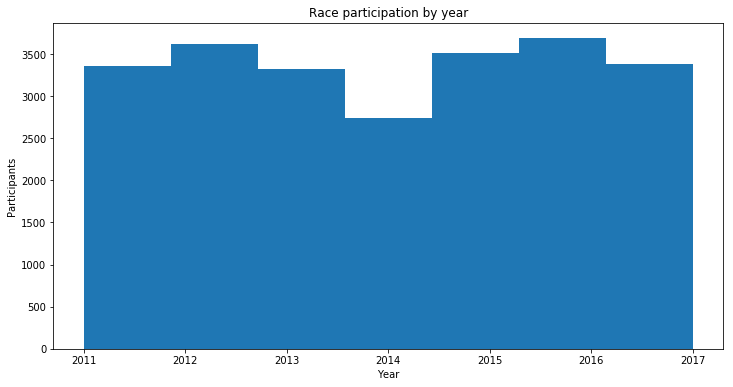

In [54]:
plt.figure(figsize=(12,6))
df['Year'].hist(grid=False,bins=7)
plt.title('Race participation by year')
plt.ylabel('Participants')
plt.xlabel('Year')

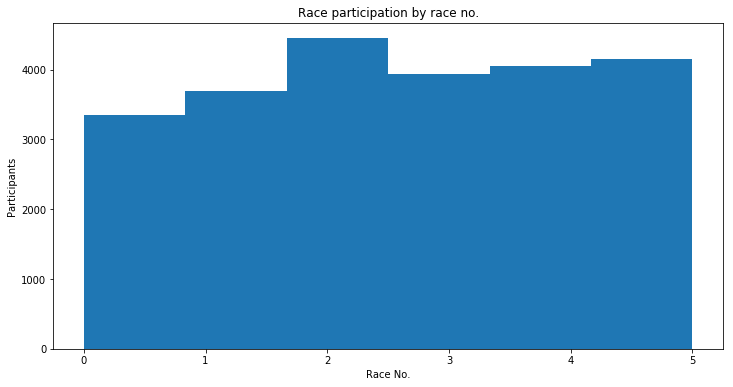

In [56]:
plt.figure(figsize=(12,6))
df['Race'].hist(grid=False,bins=6)
plt.title('Race participation by race no.')
plt.ylabel('Participants')
plt.xlabel('Race No.')

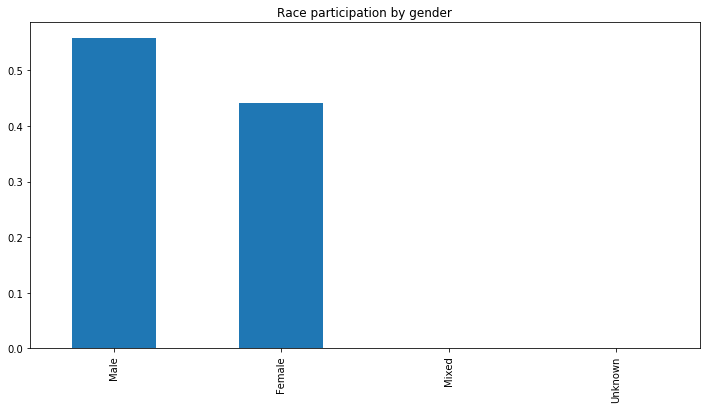

In [58]:
plt.figure(figsize=(12,6))
df['Gender'].value_counts(normalize=True).plot(kind='bar')
plt.title('Race participation by gender')

## Race times

In [96]:
# Only use races with chip timing
df2 = df[np.isfinite(df['Net Time'])]
df2 = df2[df2['Net Time'] > 0 ]
df2 = df2[df2['Net Time'] < 1000]
df2.shape

(22677, 15)

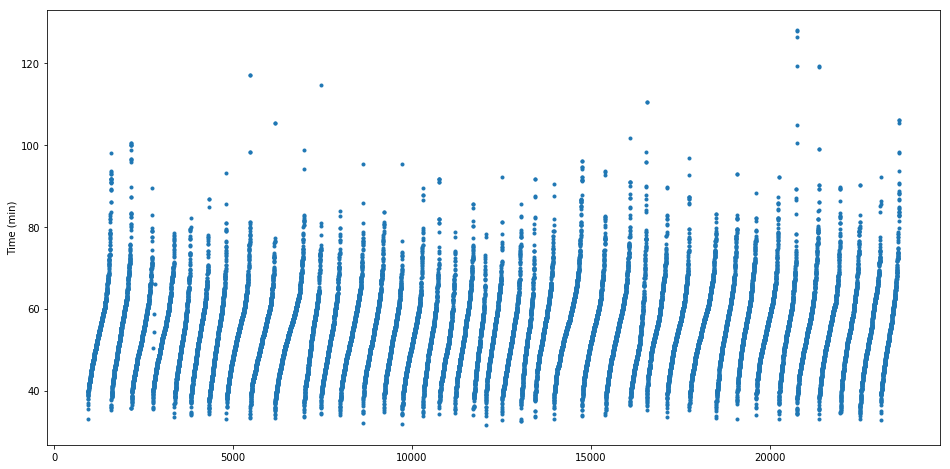

In [102]:
plt.figure(figsize=(16,8))
plt.scatter(df2.index,df2['Gun Time'],marker='.')
plt.ylabel('Time (min)')

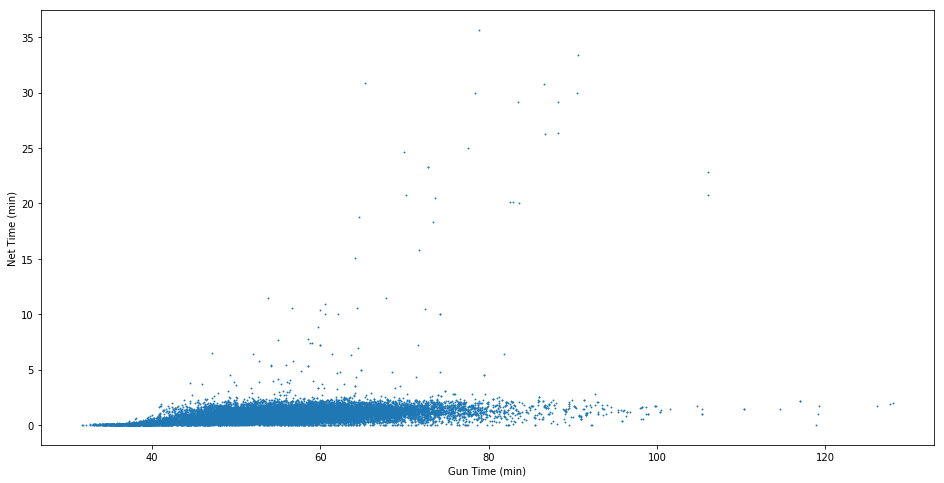

In [130]:
plt.figure(figsize=(16,8))
plt.scatter(df2['Gun Time'],df2['Gun Time']-df2['Net Time'],marker='.',s=3)
plt.xlabel('Gun Time (min)')
plt.ylabel('Net Time (min)')

(30, 100)

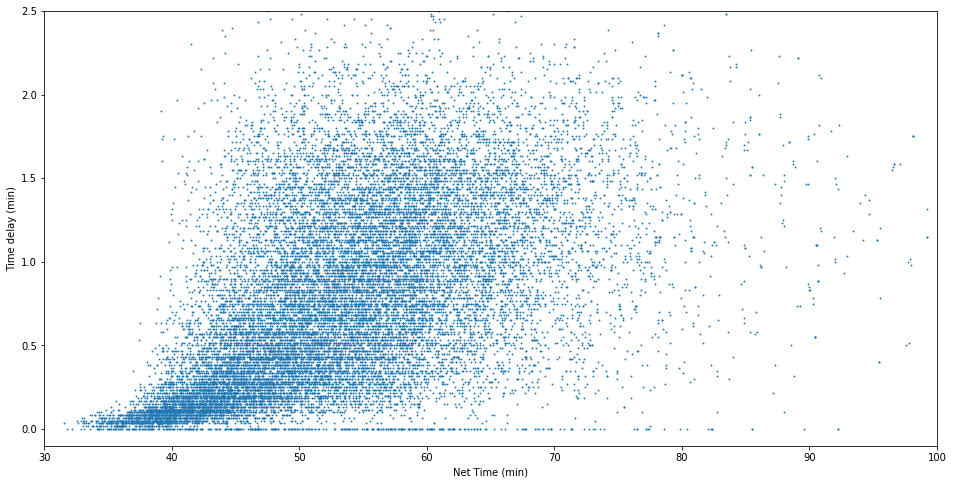

In [131]:
plt.figure(figsize=(16,8))
plt.scatter(df2['Net Time'],df2['Gun Time']-df2['Net Time'],marker='.',s=3)
plt.xlabel('Net Time (min)')
plt.ylabel('Time delay (min)')
plt.ylim([-.1,2.5])
plt.xlim([30,100])

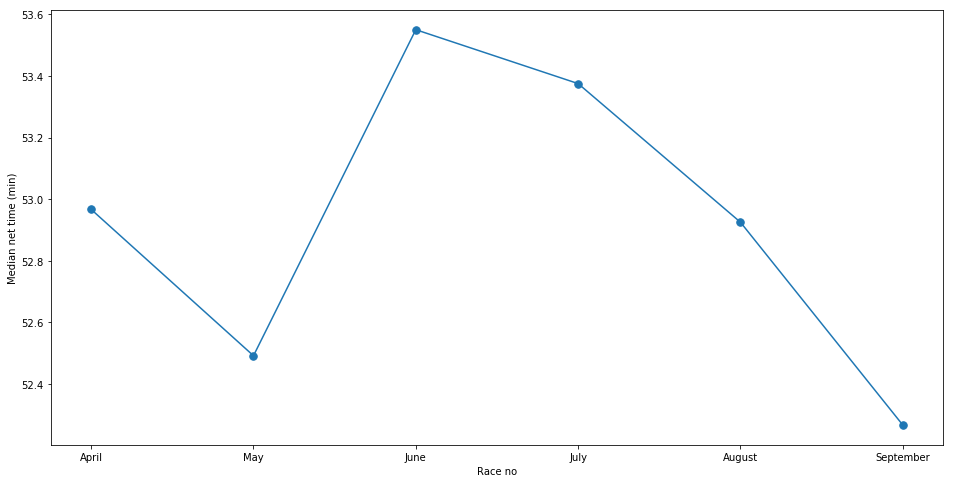

In [172]:
fig, ax = plt.subplots(figsize=(16,8))

a = df2.groupby('Race')['Net Time'].median()
axes = plt.plot(a.index, a, marker='.',markersize=15)
plt.xlabel('Race no')
plt.ylabel('Median net time (min)')
labels = ['','April','May','June','July','August','September']
ax.set_xticklabels(labels)

In [170]:
df2.groupby('Gender')['Net Time'].median()

Gender
Female     57.950000
Male       48.616667
Mixed      53.691667
Unknown    51.950000
Name: Net Time, dtype: float64